In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, confusion_matrix
from lightgbm import LGBMClassifier
from tqdm import tqdm

In [52]:
# Загрузка датасета
def load_data():
    # Чтение данных
    t = pd.read_parquet('transaction_fraud_data.parquet')
    c = pd.read_parquet('historical_currency_exchange.parquet')
    # Отсортируем данные по времени, чтобы в дальнейшем учесть временную природу данных
    t = t.sort_values('timestamp')
    return t, c

In [53]:
def eda(df: pd.DataFrame):
    fraud_rate = transactions['is_fraud'].mean()
    print(f"ОБЩИЙ ПРОЦЕНТ МОШЕННИЧЕСТВА: {fraud_rate:.2%}\n")
    print("MISSING VALUES PER COLUMN:\n", df.isna().sum(), "\n")

    plt.figure()
    sns.boxplot(x='is_fraud', y='amount_usd', data=df)
    plt.title('Amount Distribution by Fraud Status')
    plt.show()

    plt.figure()
    sns.histplot(df, x='amount_usd', hue='is_fraud', bins=50, element='step', stat='density', common_norm=False)
    plt.title('Amount Histogram by Class')
    plt.show()

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    corr = df[num_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=False, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek

    for col in ['hour', 'dayofweek']:
        plt.figure()
        rate = df.groupby(col)['is_fraud'].mean()
        rate.plot(kind='bar')
        plt.title(f'Fraud Rate by {col}')
        plt.ylabel('Rate')
        plt.show()


In [54]:
def convert_amount_to_usd_and_extract_lha_features(t: pd.DataFrame, c: pd.DataFrame):
    # Извлечем только дату
    t['date'] = t['timestamp'].dt.date
    # Подготавливаем таблицу с переводом к JOIN
    rates = c.set_index('date').stack().reset_index().rename(columns={'level_1':'currency', 0:'rate'})
    # Делаем JOIN
    t = t.merge(rates, on=['date','currency'], how='left')
    # Конвертируем суммы в доллары
    t['amount_usd'] = t['amount'] / t['rate']
    
    # Конвертация сумм из last_hour_activity: total_amount и max_single_amount
    lha = pd.json_normalize(t['last_hour_activity']).add_prefix('lha_')
    # применяем rate для lha_total_amount и lha_max_single_amount
    lha['lha_total_amount_usd'] = lha['lha_total_amount'] / t['rate'].values
    lha['lha_max_single_amount_usd'] = lha['lha_max_single_amount'] / t['rate'].values
    
    # Объединяем, удаляем лишние
    t = pd.concat([t.drop(columns=['rate']), lha], axis=1)
    return t

In [55]:
def add_time_features(t: pd.DataFrame):
    t['hour'] = t['timestamp'].dt.hour
    t['dayofweek'] = t['timestamp'].dt.dayofweek
    return t

In [56]:
def form_X_y(t: pd.DataFrame):
    # Переведём нужные колонки в категориальный тип для LightGBM
    cat_feats = ['device','vendor_category', 'vendor_type', 'channel', 'country',
                 'city', 'city_size', 'card_type', 'currency']
    for c in cat_feats:
        t[c] = t[c].astype('category')
    
    # Формируем матрицу признаков и целевой вектор
    features = [
        'amount_usd', 'is_card_present', 'is_outside_home_country',
        'is_high_risk_vendor', 'is_weekend',
        'lha_num_transactions', 'lha_total_amount_usd', 'lha_max_single_amount_usd',
        'lha_unique_merchants', 'lha_unique_countries', 'hour', 'dayofweek'
    ] + cat_feats
    X = t[features]
    y = t['is_fraud']
    return X, y

In [67]:
def train_val_test_split(X: pd.DataFrame, y: pd.DataFrame, first_border, second_border):
    # Сформируем разделение на train, val и test, учитывая время. Сплит будет 70%, 15%, 15%
    n = len(X)
    train_end, val_end = int(first_border*n), int(second_border*n)
    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

In [73]:
def tune_hyperparameters(model, X, y):
    param_dist = {
        # 'model__num_leaves': [31, 63, 127],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__n_estimators': [100, 200, 500]
    }
    tscv = TimeSeriesSplit(n_splits=5)
    search = RandomizedSearchCV(
        model, param_dist, cv=tscv,
        scoring='roc_auc', n_iter=20,
        verbose=1, n_jobs=-1, random_state=42
    )
    search.fit(X, y)
    print("\nBest params:", search.best_params_)
    return search.best_estimator_

In [58]:
def plot_precision_recall_curve(model, X_val, y_val):
    from sklearn.metrics import precision_score, recall_score
    import matplotlib.pyplot as plt
    
    # Предсказанные вероятности на валидации
    proba = model.predict_proba(X_val)[:, 1]
    
    # Подготовка списков для метрик
    thresholds = np.linspace(0, 1, 101)
    precisions = []
    recalls = []
    
    for th in tqdm(thresholds):
        preds = (proba >= th).astype(int)
        precisions.append(precision_score(y_val, preds))
        recalls.append(recall_score(y_val, preds))
    
    # Построение графика
    plt.figure()
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Metric')
    plt.title('Precision and Recall vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

In [85]:
def test_model(model, X_test, y_test, th):
    y_pred = model.predict_proba(X_test)[:, 1] > th
    print(classification_report(y_test, y_pred, target_names=['legit','fraud']))
    print('Recall test:', recall_score(y_test, y_pred), '\n')
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

In [94]:
def plot_feature_importance(model):
    feat_imps = pd.Series(
        model.feature_importances_, index=X.columns
    ).sort_values(ascending=False)
    print(feat_imps)
    # Визуализация
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,6))
    feat_imps.head(10).plot(kind='bar')
    plt.title('Feature Importances')
    plt.ylabel('Importance')
    plt.show()

In [51]:
transactions, currency = load_data()

In [60]:
transactions = convert_amount_to_usd_and_extract_lha_features(transactions, currency)

In [61]:
transactions = add_time_features(transactions)

ОБЩИЙ ПРОЦЕНТ МОШЕННИЧЕСТВА: 19.97%

MISSING VALUES PER COLUMN:
 transaction_id               0
customer_id                  0
card_number                  0
timestamp                    0
vendor_category              0
vendor_type                  0
vendor                       0
amount                       0
currency                     0
country                      0
city                         0
city_size                    0
card_type                    0
is_card_present              0
device                       0
channel                      0
device_fingerprint           0
ip_address                   0
is_outside_home_country      0
is_high_risk_vendor          0
is_weekend                   0
last_hour_activity           0
is_fraud                     0
date                         0
amount_usd                   0
lha_num_transactions         0
lha_total_amount             0
lha_unique_merchants         0
lha_unique_countries         0
lha_max_single_amount        0
lha_t

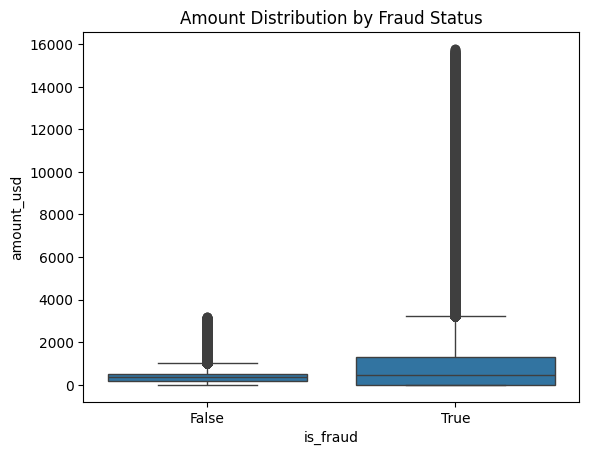

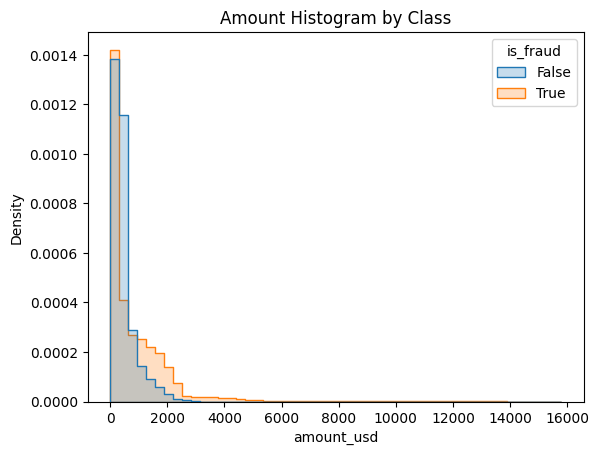

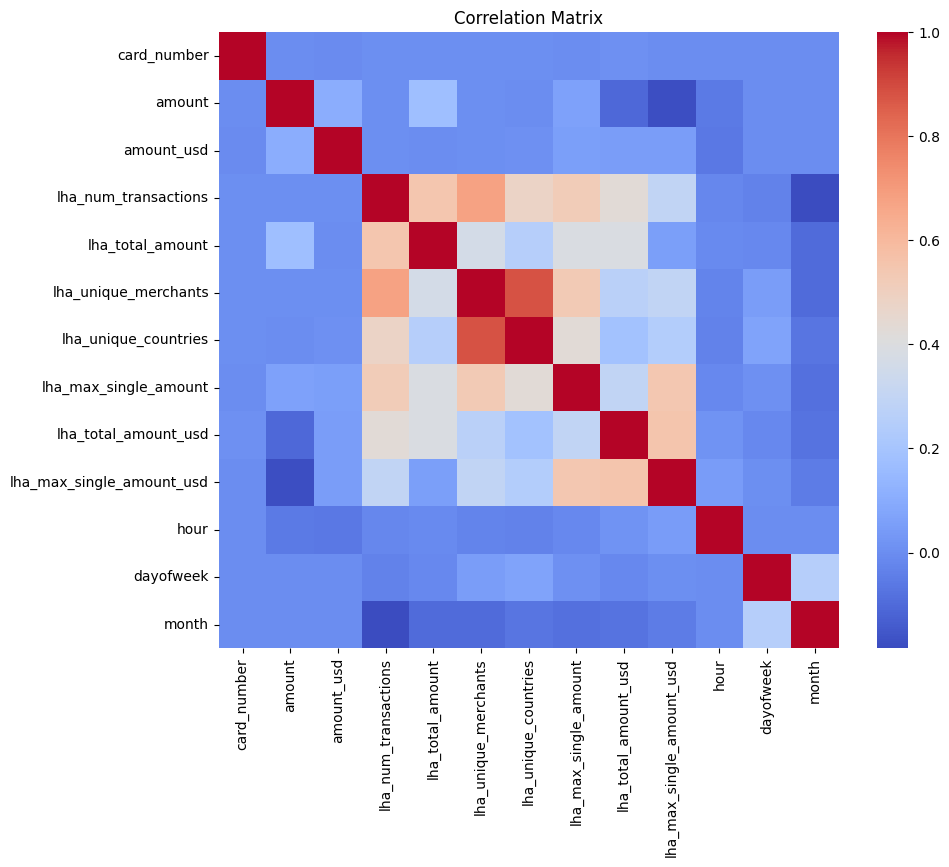

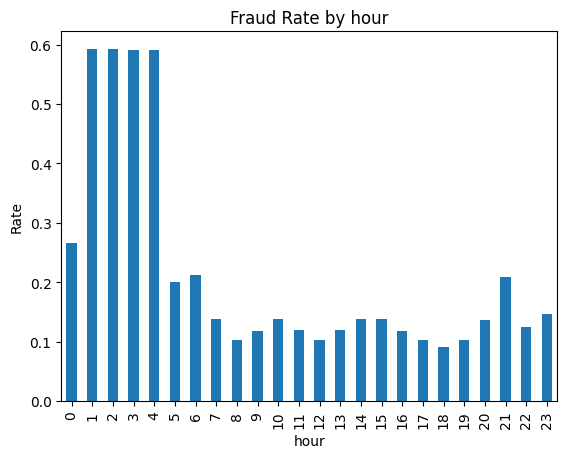

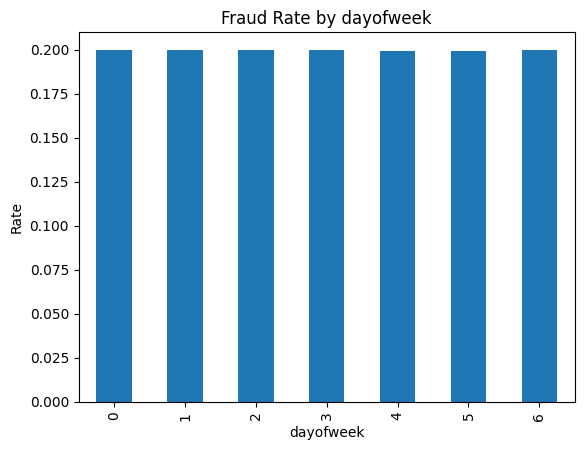

In [37]:
eda(transactions)

In [62]:
# Видим, что выборка несбалансированна. Скорее всего это повлечет в дальнейшем необходимость
# установки бОльших весов для положительных объектов, чем для отрицательных в расчете information gain 
# при построении GBDT (будем строить градиентный бустинг) или корректировки
# порога классификации для максимизации интересующих нас метрик.
# Также в данных нет пропусков, что радует.

In [63]:
X, y = form_X_y(transactions)

In [69]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, 0.7, 0.85)

In [71]:
model = LGBMClassifier(random_state=4, 
                       scale_pos_weight = y_train[y_train == 0].count() / y_train[y_train == 1].count())
# model.fit(X_train, y_train, categorical_feature=cat_feats)

In [74]:
best_model = tune_hyperparameters(model, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

C:\Users\user\anaconda3\envs\itmo_maga\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Warning] Unknown parameter: model__n_estimators
[LightGBM] [Warning] Unknown parameter: model__learning_rate
[LightGBM] [Warning] Unknown parameter: model__n_estimators
[LightGBM] [Warning] Unknown parameter: model__learning_rate
[LightGBM] [Info] Number of positive: 1282240, number of negative: 5078961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.311896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1264
[LightGBM] [Info] Number of data points in the train set: 6361201, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201572 -> initscore=-1.376498
[LightGBM] [Info] Start training from score -1.376498
Best params: {'model__n_estimators': 100, 'model__learning_rate': 0.01}


[LightGBM] [Warning] Unknown parameter: model__n_estimators
[LightGBM] [Warning] Unknown parameter: model__learning_rate


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [00:32<00:00,  3.13it/s]C:\Users\user\anaconda3\envs\itmo_maga\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:32<00:00,  3.11it/s]


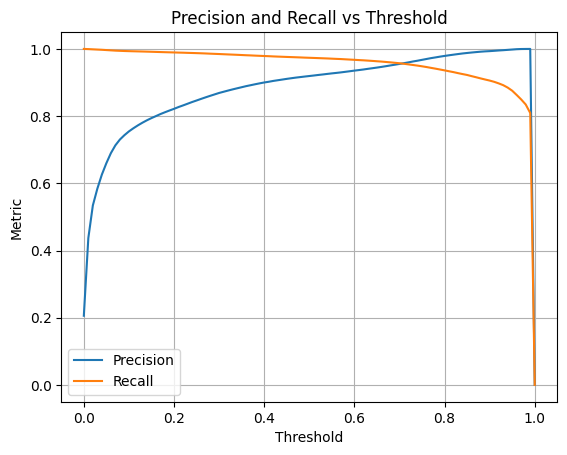

In [76]:
plot_precision_recall_curve(best_model, X_val, y_val)

In [93]:
# Окончательная оценка качества модели на тестовой выборке, порог оставим 0.5, как по стандарту,
# так как по вышепостроенному графику видно, что уменьшение порога не увеличит сильно Recall, за то
# мы сильно потеряем в Precision (будем денаить слишком много валидных операций - пользователи будут
# не довольны)
test_model(best_model, X_test, y_test, 0.5)

[LightGBM] [Warning] Unknown parameter: model__n_estimators
[LightGBM] [Warning] Unknown parameter: model__learning_rate
              precision    recall  f1-score   support

       legit       0.99      0.98      0.99    910086
       fraud       0.91      0.97      0.94    212479

    accuracy                           0.98   1122565
   macro avg       0.95      0.98      0.96   1122565
weighted avg       0.98      0.98      0.98   1122565

Recall test: 0.9718419232018223 

Confusion matrix:
 [[890579  19507]
 [  5983 206496]]


In [90]:
# С не очень большим precision получаем хороший recall, равный 97.2% на тестовой выборке. 
# Максимизация Recall нужна для того, чтобы не пропустить мошеннические операции, вес
# ошибки на которых очевидно больше, чем вес ошибки на валидных операциях
# (Нам важнее не пропустить мошеннические операции, чем ошибочно заблокировать валидные, так как 
# блокировка валидных операций обернется лишь дополнительным звонком в банк от
# пользователя и дополнительной проверкой действительно ли он делает перевод, когда мошенническая операция 
# обернется трагичными последствиями для пользователя)

amount_usd                   1018
vendor_type                   533
card_type                     445
country                       381
vendor_category               201
hour                          158
is_card_present               117
is_outside_home_country        67
lha_max_single_amount_usd      50
is_high_risk_vendor            10
lha_num_transactions            7
lha_unique_countries            6
lha_total_amount_usd            3
lha_unique_merchants            2
currency                        2
is_weekend                      0
dayofweek                       0
device                          0
channel                         0
city_size                       0
city                            0
dtype: int32


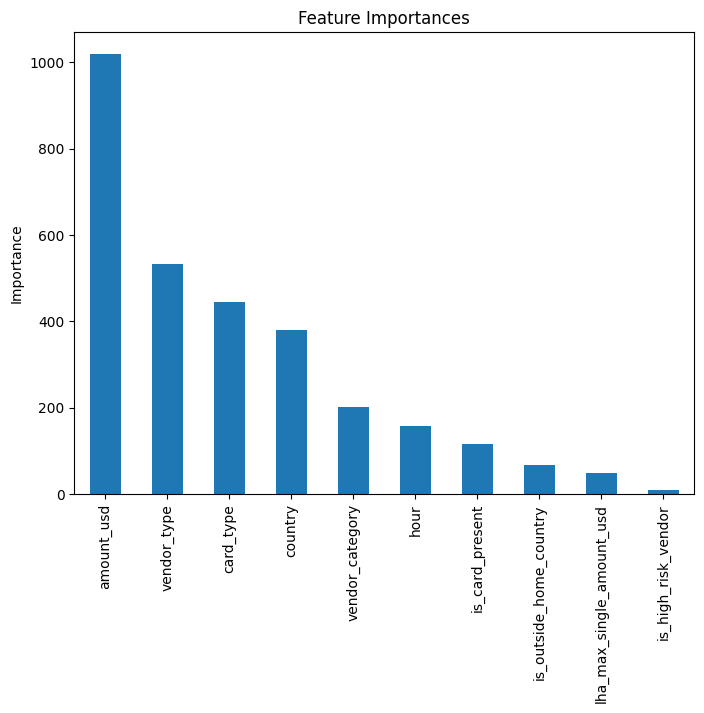

In [96]:
# Напоследок посмотрим какие признаки оказались наиболее важными для модели LightGBM, 
# получим feature_importances_
plot_feature_importance(best_model)